In [1]:
import tensorflow as tf
print('TensorFlow version: {}'.format(tf.__version__))
from tfx import v1 as tfx
print('TFX version: {}'.format(tfx.__version__))

TensorFlow version: 2.11.0
TFX version: 1.12.0


In [2]:
# Jupyter notebook Python code voor Autoencoder vraagstuk
# Auteur Kees van den Tempel, AI-labs BV, Tricht
# Versie 1.0
# 25-10-2022

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import datetime
from sklearn.preprocessing import OrdinalEncoder
from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import os

####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(2)
import random as rd
import tensorflow as tf
import pickle
#%matplotlib inline

# lees de bestanden met afbeeldingen met digits in
x_train = pd.read_csv("data/EMB_Declaraties_autoencoder_train.csv", decimal=",", sep=";", skipinitialspace=True)
x_test = pd.read_csv("data/EMB_Declaraties_autoencoder_test.csv", decimal=",", sep=";", skipinitialspace=True)

print("De x_train dataset bevat " + str(x_train.shape) + " records")
print("De x_train dataset bevat " + str(x_train.isnull().values.sum()) + " Null-waarden\n")
print("De x_test dataset bevat " + str(x_test.shape) + " records")
print("De x_test dataset bevat " + str(x_test.isnull().values.sum()) + " Null-waarden\n")

pd.options.mode.chained_assignment = None

De x_train dataset bevat (554280, 47) records
De x_train dataset bevat 0 Null-waarden

De x_test dataset bevat (61587, 47) records
De x_test dataset bevat 0 Null-waarden



In [3]:
# variabelen het verbeteren van de dataset

# variabelen voor het optimaliseren van het algoritme
HyperparameterTuning = False
# Boolean om te bepalen of kFold wordt gebruikt
UseKFold = False
# Aantal kFold iteraties
kKfold = 6
DevSet = 0.1

# Tensorboards uitproberen
# Dropout = 0.1
# Bottleneck = helft van de input layer units of percentage (zeg 80%) van oorspronkelijke units

In [4]:
x_train.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554280 entries, 0 to 554279
Data columns (total 47 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  554280 non-null  int64  
 1   LevereenheidId_1            554280 non-null  int64  
 2   LevereenheidId_2            554280 non-null  int64  
 3   LevereenheidId_3            554280 non-null  int64  
 4   LevereenheidId_4            554280 non-null  int64  
 5   LevereenheidId_5            554280 non-null  int64  
 6   LevereenheidId_6            554280 non-null  int64  
 7   ContractStatusId_1          554280 non-null  int64  
 8   ContractStatusId_2          554280 non-null  int64  
 9   ContractStatusId_3          554280 non-null  int64  
 10  ContractId_1                554280 non-null  int64  
 11  Betaalfrequentie_1          554280 non-null  int64  
 12  Betaalfrequentie_2          554280 non-null  int64  
 13  Betaalfrequent

In [5]:
# Execute onderstaande statement in de anaconda terminal
# python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"
# Gaf foutmelding dat er bepaalde dlls niet gevonden konden worden
# Computer vaak herstarten na elke installatie
# Niet vindbare dll's in de map c:\windows\system32 kopieren gaf de oplossing

# Python version:  3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
# Tensorflow version:  2.10.0
# Keras version:  2.10.0
# Cudnn version:  64_8
# Cuda version:  64_112
# Eager mode:  True
# GPU is available
# Num GPUs: 1
# 1 Physical GPUs, 1 Logical GPUs

from __future__ import absolute_import, division, print_function, unicode_literals
import sys
import numpy as np
import tensorflow as tf
import tensorflow.python.platform.build_info as build
from tensorflow import keras

version = tf.__version__
executing_eagerly = tf.executing_eagerly()
available = tf.config.experimental.list_physical_devices("GPU")
physical_devices = tf.config.list_physical_devices('GPU')

print("Python version: ", sys.version)
print("Tensorflow version: ", version)
print("Keras version: ", keras.__version__)
#print("Cudnn version: ", build.build_info['cudnn_version'])
#print("Cuda version: ", build.build_info['cuda_version'])
print("Eager mode: ", executing_eagerly)
print("GPU is", "available" if available else "NOT AVAILABLE")
print("Num GPUs:", len(physical_devices))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Python version:  3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Tensorflow version:  2.11.0
Keras version:  2.11.0
Eager mode:  True
GPU is NOT AVAILABLE
Num GPUs: 0


In [6]:
# init deterministic seed
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(2)
   tf.random.set_seed(2)
   np.random.seed(2)
   rd.seed(2)


In [7]:
pd.set_option('display.max_columns', None)
x_train.head(10)

,Unnamed: 0,LevereenheidId_1,LevereenheidId_2,LevereenheidId_3,LevereenheidId_4,LevereenheidId_5,LevereenheidId_6,ContractStatusId_1,ContractStatusId_2,ContractStatusId_3,ContractId_1,Betaalfrequentie_1,Betaalfrequentie_2,Betaalfrequentie_3,Betaalfrequentie_4,EenhedenDeler_1,EenhedenDeler_2,KalenderJaar_1,KalenderJaar_2,KalenderJaar_3,KalenderJaar_4,KalenderJaar_5,KalenderJaar_6,KalenderJaar_7,DeclaratieId,Hoeveelheids,Periodenummer,GedeclareerdeTariefExclBtw,GemeenteId_emb,TeamId_emb,BudgettypeId_emb,nProductID_emb,nAanbiederID_emb,__ContractDuur,__MeanProductDecl,__AantalProductDecl,__MeanAanbiederDecl,__StdDevAanbiederDecl,__AantalAanbiederDecl,__DeclaratiePeriode,__MeanProductDeclduur,__MeanAanbiederDeclduur,__StdDevClientDeclduur,__EerdereDeclaraties,__Volgnummer,__EerdereDeclaratieduur,GedeclareerdeKostenExclBtw
0,305254,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,2792293,0.000002,0.663123,0.000127,3.0,2.0,3.0,8.0,14.0,0.000431,0.028270,1.000000,0.016773,0.036508,0.153137,0.000000,0.118938,0.140182,0.086592,0.007564,0.019017,0.144339,0.038335
1,190386,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,2350117,0.000003,0.992709,0.000070,3.0,4.0,1.0,13.0,7.0,0.008534,0.015654,0.056037,0.010476,0.017927,0.247636,0.026291,0.067995,0.063664,0.026038,0.013984,0.198098,0.342697,0.038640
2,532373,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,3587963,0.000002,0.992709,0.000104,7.0,7.0,1.0,28.0,10.0,0.008707,0.017574,0.238165,0.008180,0.007955,0.077638,0.000000,0.035839,0.029341,0.027098,0.004980,0.041204,0.341400,0.038705
3,39576,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1610490,0.000002,0.663123,0.000295,14.0,1.0,4.0,4.0,28.0,0.000948,0.004411,0.018278,0.014046,0.022222,1.000000,0.000000,0.001838,0.003659,0.018371,0.007431,0.064976,0.051858,0.038316
4,434966,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,3197825,0.000002,0.239316,0.000138,1.0,1.0,1.0,25.0,7.0,0.009138,0.016132,0.057385,0.010476,0.017927,0.247636,0.028169,0.060772,0.063664,0.026650,0.005357,0.055468,0.275713,0.038636
5,191357,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,2122783,0.000002,0.822984,0.001251,3.0,2.0,3.0,8.0,15.0,0.000690,0.028270,1.000000,0.008737,0.014472,0.068403,0.227230,0.118938,0.090140,0.171063,0.003247,0.001585,0.158168,0.039507
6,168372,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1692898,0.000002,-0.822984,0.000213,5.0,5.0,4.0,0.0,20.0,0.008534,0.010735,0.414822,0.018215,0.031996,0.520479,0.000000,0.000852,0.000765,0.043180,0.013264,0.150555,0.289542,0.039634
7,270416,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,2681394,0.000002,0.822984,0.000469,2.0,8.0,6.0,26.0,29.0,0.000431,0.014238,0.114149,0.010145,0.009422,0.072626,0.000000,0.047491,0.000000,0.030012,0.013794,0.179081,0.500432,0.038755
8,96781,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1640877,0.000002,-0.464723,0.000164,3.0,2.0,4.0,20.0,28.0,0.000948,0.124212,0.031802,0.014046,0.022222,1.000000,0.000000,0.018088,0.003659,0.017024,0.012424,0.058637,0.144339,0.043193
9,92381,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1534052,0.000002,-0.822984,0.000213,3.0,2.0,4.0,0.0,20.0,0.000948,0.010735,0.414822,0.018215,0.031996,0.520479,0.000000,0.000852,0.000765,0.018180,0.005527,0.053883,0.131374,0.038317


In [8]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and dev-sets
if DevSet > 0:
    x_train, x_dev = train_test_split(x_train, test_size = DevSet, random_state = 42)
    print('Dimensie van de trainingset x_train:' + str (x_train.shape))
    print('Dimensie van de testset x_test:' + str(x_test.shape))
    print('Dimensie van de dev-set x_dev:' + str(x_dev.shape) + '\n')

Dimensie van de trainingset x_train:(498852, 47)
Dimensie van de testset x_test:(61587, 47)
Dimensie van de dev-set x_dev:(55428, 47)



In [9]:
def DeleteVars(df):
    df.drop(['Unnamed: 0', 'DeclaratieId'], axis=1, inplace=True)

    volgnummers = [var for var in df.columns if '__Volgnummer' in var]
    # print(volgnummers)
    df.drop(volgnummers, axis=1, inplace=True)

    #gemeenten = [var for var in df.columns if 'Gemeente' in var]
    #print(gemeenten)
    #df.drop(gemeenten, axis=1, inplace=True)

    #client = [var for var in df.columns if 'Client' in var]
    #print(client)
    #df.drop(client, axis=1, inplace=True)

    contract = [var for var in df.columns if 'ContractId' in var]
    print(contract)
    df.drop(contract, axis=1, inplace=True)

DID_train = x_train['DeclaratieId']
DID_test = x_test['DeclaratieId']
DID_test = x_dev['DeclaratieId']
DeleteVars(x_train)
DeleteVars(x_test)
DeleteVars(x_dev)

['ContractId_1']
['ContractId_1']
['ContractId_1']


In [10]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498852 entries, 132025 to 121958
Data columns (total 43 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   LevereenheidId_1            498852 non-null  int64  
 1   LevereenheidId_2            498852 non-null  int64  
 2   LevereenheidId_3            498852 non-null  int64  
 3   LevereenheidId_4            498852 non-null  int64  
 4   LevereenheidId_5            498852 non-null  int64  
 5   LevereenheidId_6            498852 non-null  int64  
 6   ContractStatusId_1          498852 non-null  int64  
 7   ContractStatusId_2          498852 non-null  int64  
 8   ContractStatusId_3          498852 non-null  int64  
 9   Betaalfrequentie_1          498852 non-null  int64  
 10  Betaalfrequentie_2          498852 non-null  int64  
 11  Betaalfrequentie_3          498852 non-null  int64  
 12  Betaalfrequentie_4          498852 non-null  int64  
 13  EenhedenD

In [11]:
#Split the trainingdata in two sets: one that will be embedded (categorical features) and one with remaining features
    
Cat_features =  [var for var in x_train.columns if '_emb' in var]
print("Cat_features : " + str(Cat_features))

Num_features =  [var for var in x_train.columns if '_emb' not in var]
print("Num_features : " + str(Num_features))

#Three numerical variables
x_train_num = x_train[Num_features]
x_test_num = x_test[Num_features]
if DevSet > 0: x_dev_num = x_dev[Num_features]

#One categorical variables with 4 levels
x_train_emb = x_train[Cat_features]
x_test_emb = x_test[Cat_features]
if DevSet > 0: x_dev_emb = x_dev[Cat_features]

if 1==2:
    #Three numerical variables
    x_train_num = x_train.copy().drop(Cat_features, axis=1, inplace=True)
    x_test_num = x_test.copy().drop(Cat_features, axis=1, inplace=True)
    if DevSet > 0: x_dev_num = x_dev.copy().drop(Cat_features, axis=1, inplace=True)

    #One categorical variables with 4 levels
    x_train_emb = x_train.copy().drop(Num_features, axis=1, inplace=True)
    x_test_emb = x_test.copy().drop(Num_features, axis=1, inplace=True)
    if DevSet > 0: x_dev_emb = x_dev.copy().drop(Num_features, axis=1, inplace=True)


Cat_features : ['GemeenteId_emb', 'TeamId_emb', 'BudgettypeId_emb', 'nProductID_emb', 'nAanbiederID_emb']
Num_features : ['LevereenheidId_1', 'LevereenheidId_2', 'LevereenheidId_3', 'LevereenheidId_4', 'LevereenheidId_5', 'LevereenheidId_6', 'ContractStatusId_1', 'ContractStatusId_2', 'ContractStatusId_3', 'Betaalfrequentie_1', 'Betaalfrequentie_2', 'Betaalfrequentie_3', 'Betaalfrequentie_4', 'EenhedenDeler_1', 'EenhedenDeler_2', 'KalenderJaar_1', 'KalenderJaar_2', 'KalenderJaar_3', 'KalenderJaar_4', 'KalenderJaar_5', 'KalenderJaar_6', 'KalenderJaar_7', 'Hoeveelheids', 'Periodenummer', 'GedeclareerdeTariefExclBtw', '__ContractDuur', '__MeanProductDecl', '__AantalProductDecl', '__MeanAanbiederDecl', '__StdDevAanbiederDecl', '__AantalAanbiederDecl', '__DeclaratiePeriode', '__MeanProductDeclduur', '__MeanAanbiederDeclduur', '__StdDevClientDeclduur', '__EerdereDeclaraties', '__EerdereDeclaratieduur', 'GedeclareerdeKostenExclBtw']


In [12]:
# Splits de digits-dataset in een training- en een testset voor het machine learning model
# Eerst moet er een training en test set gemaakt worden om daarna allerlei bewerkingen en filters toe te passen
# om zo data leakage te voorkomen

print(str(type(x_train_emb)) + ': x_train_emb Shape:', x_train_emb.shape)
print(str(type(x_test_emb)) + ': x_test_emb Shape:', x_test_emb.shape)
print(str(type(x_dev_emb)) + ': x_test_emb Shape:', x_dev_emb.shape)

print(str(type(x_train_num)) + ': x_train_num Shape:', x_train_num.shape)
print(str(type(x_test_num)) + ': x_test_num Shape:', x_test_num.shape)
print(str(type(x_dev_num)) + ': x_test_num Shape:', x_dev_num.shape)

<class 'pandas.core.frame.DataFrame'>: x_train_emb Shape: (498852, 5)
<class 'pandas.core.frame.DataFrame'>: x_test_emb Shape: (61587, 5)
<class 'pandas.core.frame.DataFrame'>: x_test_emb Shape: (55428, 5)
<class 'pandas.core.frame.DataFrame'>: x_train_num Shape: (498852, 38)
<class 'pandas.core.frame.DataFrame'>: x_test_num Shape: (61587, 38)
<class 'pandas.core.frame.DataFrame'>: x_test_num Shape: (55428, 38)


In [13]:
#Schakel over van panda.dataframes naar numpy arrays
x_train_emb = np.array(x_train_emb)
x_test_emb = np.array(x_test_emb)
x_dev_emb = np.array(x_test_emb)

x_train_num = np.array(x_train_num)
x_test_num = np.array(x_test_num)
x_dev_num = np.array(x_test_num)

print ("X-train (de cat training kenmerken)" + str(x_train_emb.shape))
print ("X-test (de cat test kenmerken)" + str(x_test_emb.shape))
print ("X-dev (de cat dev kenmerken)" + str(x_dev_emb.shape))

print ("\nX-train (de num training kenmerken)" + str(x_train_num.shape))
print ("X-test (de num test kenmerken)" + str(x_test_num.shape))
print ("X-dev (de num dev kenmerken)" + str(x_dev_num.shape))

X-train (de cat training kenmerken)(498852, 5)
X-test (de cat test kenmerken)(61587, 5)
X-dev (de cat dev kenmerken)(61587, 5)

X-train (de num training kenmerken)(498852, 38)
X-test (de num test kenmerken)(61587, 38)
X-dev (de num dev kenmerken)(61587, 38)


In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM, BatchNormalization, Conv2D, Input, MaxPool2D,Flatten, Permute, GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras import initializers, activations
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import CosineSimilarity
from tensorflow.keras import regularizers
from keras.losses import mean_squared_error
from keras.layers import LeakyReLU
from tensorflow.keras.layers import Lambda

# define the global variables / hyperparameters for the neural network
# Define functions

def SelectOptimizer(i, lr):
    if i==1:
        tmp = Adam(learning_rate=lr, epsilon=1e-07)
    elif i==2:
        tmp = Nadam(learning_rate=lr, epsilon=1e-07)
    elif i==3:
        tmp = SGD(learning_rate=lr, momentum=0.8, nesterov=False)
    elif i==4:
        tmp = SGD(learning_rate=lr, momentum=0.8, nesterov=True)
    elif i==5:
        tmp = RMSprop(learning_rate=lr, momentum=0.8, epsilon=1e-07)
    return tmp

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis = None))

epochs = 100

# initial learning rate
learning_rate = 0.008 
# decay_rate = learning_rate / epochs
decay_rate = 0.05

momentum = 0.8
Reg = 0.0
DropoutVal = 0
OptIndex = 2

StartLayer = x_train.shape[1]
InnerLayer2 = 60
InnerLayer3 = 30
InnerLayer4 = 0
InnerLayer5 = 0
InnerLayer6 = 0
InnerLayer7 = 0
LatentLayer = 12

opt = SelectOptimizer(2, 0.01)
kregularizer=regularizers.L2(0.01)
bSize = 16384
initializer = initializers.GlorotUniform(seed=0)

blnLabelEncode=False

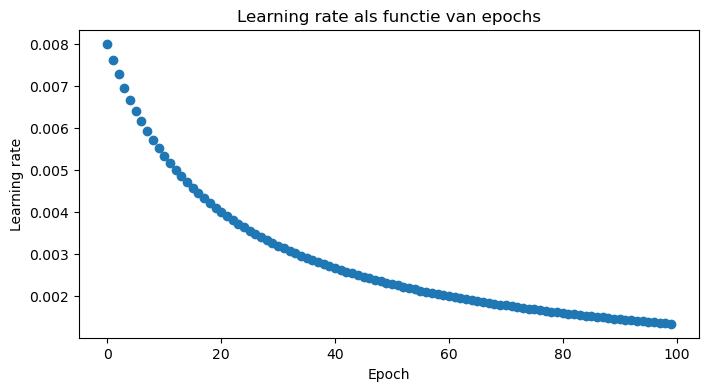

In [15]:
# LEARNING RATE
# Veranderende learning rate instellen via een callback functie in Keras
# Ook wordt er een plot gemaakt van de learning rate
# https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
# https://towardsdatascience.com/simple-guide-to-hyperparameter-tuning-in-neural-networks-3fe03dad8594

# Define the Required Callback Functions
from keras.callbacks import LearningRateScheduler

def exp_decay(epoch):
    #lrate = learning_rate * np.exp(-decay_rate*float(epoch))          #exponentieel
    lrate = learning_rate * 1/(1 + decay_rate * epoch)                #assymptoot naar 0
    #lrate = (((0.002-learning_rate)/epochs) * epoch) + learning_rate   #lineair naar 0
    return lrate

lr_rate = LearningRateScheduler(exp_decay)

class StopTraining(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # if(logs.get('accuracy')>0.99) or (logs.get('val_loss')<0.001):
        if (logs.get('val_loss')<0.001):
            print("\n99% val_accuracy bereikt, dus algorithme stopt met trainen")
            self.model.stop_training = True


# een grafiek maken van de learning rate\
x = list(range(0,epochs))
y = []
for i in x: y.append(exp_decay(i))
fig, axs = plt.subplots(figsize=(8, 4))
axs.scatter(x, y)
axs.set_title('Learning rate als functie van epochs')
axs.set(xlabel='Epoch', ylabel='Learning rate')
plt.show() 



Definieer AutoEncoder Neuraal netwerk
no_of_unique_emb: 19  embedding_size: 12
no_of_unique_emb: 16  embedding_size: 10
no_of_unique_emb: 9  embedding_size: 6
no_of_unique_emb: 36  embedding_size: 20
no_of_unique_emb: 32  embedding_size: 20
Lengte totale input vector: 106
Model: "VAEencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 tf_op_layer_strided_slice (Ten  [(None,)]           0           ['input_1[0][0]']                
 sorFlowOpLayer)                                                                                  
                                                                                                  
 tf_op_layer_

 input_1 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 VAEencoder (Functional)        (None, 12)           10864       ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 VAEdecoder (Functional)        (None, 43)           4873        ['VAEencoder[0][0]']             
                                                                                                  
Total params: 15,737
Trainable params: 15,737
Non-trainable params: 0
_______________________________________

C:\Users\kvdte\anaconda3\lib\site-packages\keras\engine\training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


498852/498852 [==============================] - 2s 5us/sample - loss: 5866593.6682 - mse: 8.3473 - mae: 1.2539 - mape: 295260032.0000 - accuracy: 0.6009 - val_loss: 1332072.9700 - val_mse: 1.9875 - val_mae: 0.6628 - val_mape: 156290768.0000 - val_accuracy: 0.8941 - lr: 0.0080
Epoch 2/100
498852/498852 [==============================] - 2s 4us/sample - loss: 1318168.6287 - mse: 1.8803 - mae: 0.7460 - mape: 203106576.0000 - accuracy: 0.8719 - val_loss: 450489.5298 - val_mse: 0.6720 - val_mae: 0.4678 - val_mape: 134195040.0000 - val_accuracy: 0.9141 - lr: 0.0076
Epoch 3/100
498852/498852 [==============================] - 2s 4us/sample - loss: 584939.3549 - mse: 0.8350 - mae: 0.5074 - mape: 136054544.0000 - accuracy: 0.9121 - val_loss: 247533.0607 - val_mse: 0.3693 - val_mae: 0.3376 - val_mape: 97466152.0000 - val_accuracy: 0.9537 - lr: 0.0073
Epoch 4/100
498852/498852 [==============================] - 2s 4us/sample - loss: 349715.3532 - mse: 0.4998 - mae: 0.4207 - mape: 125943408.0000 

Epoch 30/100
498852/498852 [==============================] - 2s 4us/sample - loss: 49923.6171 - mse: 0.0717 - mae: 0.1670 - mape: 54991148.0000 - accuracy: 0.9770 - val_loss: 34593.8348 - val_mse: 0.0515 - val_mae: 0.1445 - val_mape: 51049584.0000 - val_accuracy: 0.9784 - lr: 0.0033
Epoch 31/100
498852/498852 [==============================] - 2s 4us/sample - loss: 39393.9501 - mse: 0.0565 - mae: 0.1473 - mape: 50244220.0000 - accuracy: 0.9765 - val_loss: 32063.7100 - val_mse: 0.0477 - val_mae: 0.1358 - val_mape: 48667024.0000 - val_accuracy: 0.9847 - lr: 0.0032
Epoch 32/100
498852/498852 [==============================] - 2s 4us/sample - loss: 47257.8244 - mse: 0.0680 - mae: 0.1637 - mape: 55730940.0000 - accuracy: 0.9705 - val_loss: 33359.8367 - val_mse: 0.0497 - val_mae: 0.1411 - val_mape: 50085540.0000 - val_accuracy: 0.9860 - lr: 0.0031
Epoch 33/100
498852/498852 [==============================] - 2s 4us/sample - loss: 37013.1123 - mse: 0.0530 - mae: 0.1475 - mape: 52199540.0000 

Epoch 59/100
498852/498852 [==============================] - 2s 4us/sample - loss: 28864.5697 - mse: 0.0414 - mae: 0.1255 - mape: 44736524.0000 - accuracy: 0.9788 - val_loss: 22952.5741 - val_mse: 0.0341 - val_mae: 0.1137 - val_mape: 42999500.0000 - val_accuracy: 0.9855 - lr: 0.0021
Epoch 60/100
498852/498852 [==============================] - 2s 4us/sample - loss: 29277.6863 - mse: 0.0419 - mae: 0.1270 - mape: 45774000.0000 - accuracy: 0.9791 - val_loss: 22379.6228 - val_mse: 0.0332 - val_mae: 0.1114 - val_mape: 42360588.0000 - val_accuracy: 0.9854 - lr: 0.0020
Epoch 61/100
498852/498852 [==============================] - 2s 4us/sample - loss: 24905.4224 - mse: 0.0356 - mae: 0.1174 - mape: 44374280.0000 - accuracy: 0.9795 - val_loss: 21471.3971 - val_mse: 0.0319 - val_mae: 0.1085 - val_mape: 42179964.0000 - val_accuracy: 0.9841 - lr: 0.0020
Epoch 62/100
498852/498852 [==============================] - 2s 4us/sample - loss: 27872.5376 - mse: 0.0400 - mae: 0.1251 - mape: 45848556.0000 

Epoch 88/100
498852/498852 [==============================] - 2s 4us/sample - loss: 19312.6647 - mse: 0.0276 - mae: 0.1032 - mape: 39882856.0000 - accuracy: 0.9805 - val_loss: 16732.6788 - val_mse: 0.0248 - val_mae: 0.0936 - val_mape: 37902516.0000 - val_accuracy: 0.9789 - lr: 0.0015
Epoch 89/100
498852/498852 [==============================] - 2s 4us/sample - loss: 20399.8019 - mse: 0.0292 - mae: 0.1041 - mape: 39745092.0000 - accuracy: 0.9780 - val_loss: 16810.5199 - val_mse: 0.0249 - val_mae: 0.0938 - val_mape: 38058380.0000 - val_accuracy: 0.9738 - lr: 0.0015
Epoch 90/100
498852/498852 [==============================] - 2s 4us/sample - loss: 22186.0447 - mse: 0.0317 - mae: 0.1100 - mape: 41518944.0000 - accuracy: 0.9760 - val_loss: 16938.5662 - val_mse: 0.0251 - val_mae: 0.0947 - val_mape: 38168520.0000 - val_accuracy: 0.9726 - lr: 0.0015
Epoch 91/100
498852/498852 [==============================] - 2s 4us/sample - loss: 19455.9754 - mse: 0.0278 - mae: 0.1024 - mape: 39492428.0000 

C:\Users\kvdte\anaconda3\lib\site-packages\keras\engine\training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


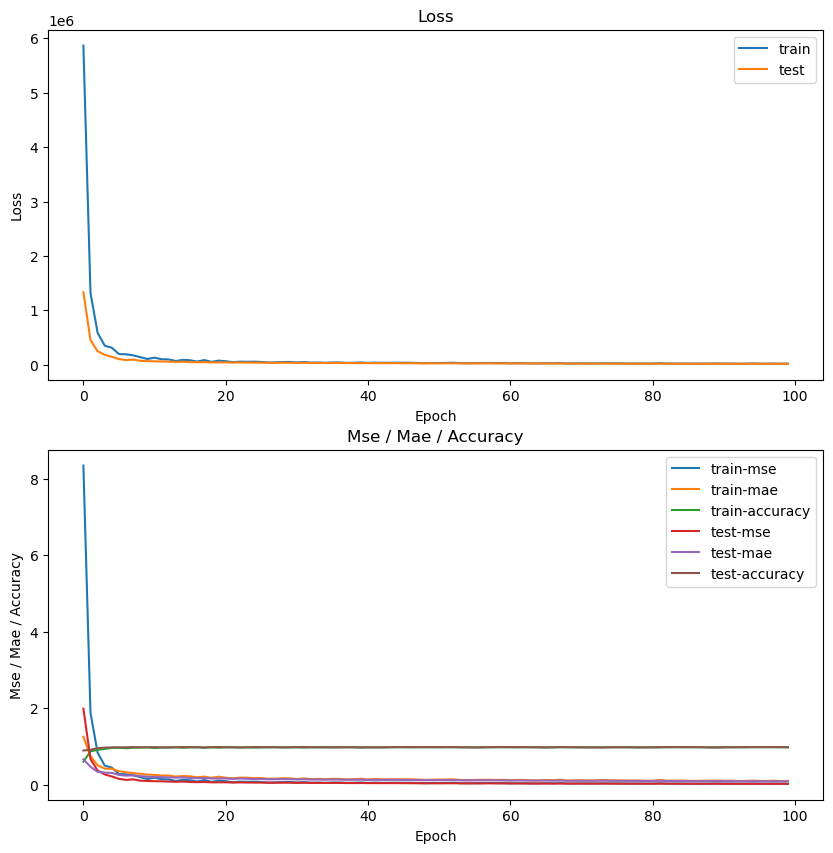

dict_keys(['loss', 'mse', 'mae', 'mape', 'accuracy', 'val_loss', 'val_mse', 'val_mae', 'val_mape', 'val_accuracy', 'lr'])


In [16]:
# Voer neuraal netwerk uit met EMBEDDING layers gecombineerd met standaard numerical input  
# Docs over het combineren van Entity embedding en andere features:
# https://mmuratarat.github.io/2019-06-12/embeddings-with-numeric-variables-Keras
# https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/
    
import matplotlib.pyplot as plt
from keras.callbacks import History
from sklearn.utils import compute_class_weight
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
from keras.layers import LeakyReLU

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# Dit zorgt er voor dat waarschuwingen niet zichtbaar worden
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    return total_loss

# UITLEG OPZET EMBEDDING
# Voor elke feature waarvoor embedding wordt toegepast, worden 2 lagen gemaakt:
# 1. De input_layer die de shape definiteerd
# 2. De embedding layer, die de transformatie van een waarde naar een vector doet. 
# Voor de vector wordt een waarde genomen, gelijk aan het aantal categorische waarden (no_of_unique_emb) gedeeld door 2

# no_of_unique_emb = is het aantal categorische waarden, voor elke feature dus anders
# inp_emb_layers = lijst van input layers van elke categorical feature
# emb_layers = lijst van embedding layers van elke categorical feature
# embedding_size is de lengte van de output-vector
# prepare input data

with tf.device("cpu:0"):
    # Autoencoder
    print("\nDefinieer AutoEncoder Neuraal netwerk")
    reset_random_seeds()
    
    # prepare an input head for ech categorical feature
    emb_layers = list()
    x_train_emb_lst, x_test_emb_lst, x_dev_emb_lst = list(), list(), list()
    TotalEmbeddingSize = 0
    global z_mean
    global z_log_var
    Summary=True
    
    inp_emb_data = tf.keras.layers.Input(shape=(len(Cat_features),))
    for i in range(len(Cat_features)):
        # NOW start preparing embedding: first calculate the number of unique inputs
        # no_of_unique_emb = len(np.unique(np.concatenate((x_train_emb[:,i], x_test_emb[:,i]), axis=0)))
        
        if blnLabelEncode==True:
            # Define a LabelEncoder for this categorical feature
            le = LabelEncoder()
            le.fit(x_train_emb[:, i])
            
            # Transform the categorical data using the LabelEncoder
            x_train_emb[:, i] = le.transform(x_train_emb[:, i])
            x_test_emb[:, i] = le.transform(x_test_emb[:, i])

        no_of_unique_emb = len(np.unique(x_train_emb[:,i]))

        # The output of the embedding layer will be a three-dimensional Keras Tensor with shape 
        # shape = (batch_size, input_length, output_dim) 
        # input_length is the length of the input sequence (i.e., number of input features)
        # output_dim is the dimensionality of the output feature vectors produced by the embedding layer.

        embedding_size = min(np.ceil((no_of_unique_emb)/1.666), 20)
        embedding_size = int(embedding_size)
        
        TotalEmbeddingSize = TotalEmbeddingSize + embedding_size
        # lambda_layer = Lambda(lambda x: x[:, i])(inp_emb_data)
        
        # Compute the maximum value for this categorical feature
        print("no_of_unique_emb: " + str(no_of_unique_emb) + "  embedding_size: " + str(embedding_size))

        # Define the input and embedding layers for this categorical feature
        emb_layer = tf.keras.layers.Embedding(input_dim=no_of_unique_emb+1, output_dim=embedding_size, input_length=1)(inp_emb_data[:, i])
        flattened_layr = tf.keras.layers.Flatten()(emb_layer)
        # emb_layer = tf.keras.layers.Embedding(no_of_unique_emb, embedding_size)(lambda_layer)
        # flattened_layr = Flatten()(emb_layer)

        # store layers
        emb_layers.append(flattened_layr)

    # Define the input layer for the remaining numerical data (excl categorical features)
    inp_num_data = tf.keras.layers.Input(shape=(len(Num_features),))

    # concat all output layers : this is the flattend output of all categorical embedded features and 
    # the remaining numerical features (inp_num_data)
    merge = keras.layers.Concatenate()(emb_layers +[inp_num_data])
    # Emb_output = Lambda(lambda x: x)(merge)
    # EMBmodel = Model([inp_emb_data, inp_num_data], Emb_output, name='EmbeddingModel')
    # if Summary==True: EMBmodel.summary()
    
    print("Lengte totale input vector: " + str(TotalEmbeddingSize+len(Num_features)))
    
    # Define the ENCODER part of the Variational Auto Encoder
    # encoder_inputs = tf.keras.Input(shape=(TotalEmbeddingSize+len(Num_features),), name='encoder_input')
    if InnerLayer2>0:
        x = Dense(InnerLayer2, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(Reg))(merge)
        if DropoutVal>0: x = Dropout(DropoutVal)(x)
    if InnerLayer3>0:
        x = Dense(InnerLayer3, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(Reg))(x)
        if DropoutVal>0: x = Dropout(DropoutVal)(x)
    if InnerLayer4>0:
        x = Dense(InnerLayer4, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(Reg))(x)
        if DropoutVal>0: x = Dropout(DropoutVal)(x)
    z_mean = Dense(LatentLayer, name='z_mean')(x)
    z_log_var = Dense(LatentLayer, name='z_log_var')(x)
    
    # use the reparameterization trick and get the output from the sample() function
    z = Lambda(sample, output_shape=(LatentLayer,), name='z')([z_mean, z_log_var])
    encoder = Model([inp_emb_data, inp_num_data], z, name='VAEencoder')
    if Summary==True: encoder.summary()    
        
    # Define the DECODER part of the Variational Auto Encoder
    latent_inputs = keras.Input(shape=(LatentLayer,), name='z_sampling')
    x = latent_inputs
    if InnerLayer4>0:
        x = Dense(InnerLayer4, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(Reg))(x)
        if DropoutVal>0: x = Dropout(DropoutVal)(x)
    if InnerLayer3>0:
        x = Dense(InnerLayer3, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(Reg))(x)
        if DropoutVal>0: x = Dropout(DropoutVal)(x)
    if InnerLayer2>0:
        x = Dense(InnerLayer2, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(Reg))(x)
        if DropoutVal>0: x = Dropout(DropoutVal)(x)
    decoder_outputs = Dense(units=StartLayer, activation="linear", kernel_regularizer=l2(Reg), kernel_initializer='he_normal')(x)
    decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="VAEdecoder")
    if Summary==True: decoder.summary()

    if 1==2:
        # full VAE model
        # https://towardsdatascience.com/hands-on-anomaly-detection-with-variational-autoencoders-d4044672acd5
        EMDOutputs = EMBmodel([inp_emb_data, inp_num_data], Emb_output)
        VAEoutputs = decoder(encoder(encoder_inputs))
        tModel = VAE
        VAEmodel = Model([inp_emb_data, inp_num_data], VAEoutputs, name='vae_mlp')
    
    # Use the decoder model to decode the encoded data
    # Use the encoder model to encode the input data
    encoded = encoder([inp_emb_data, inp_num_data])

    # Use the decoder model to decode the encoded data
    AEoutputs = decoder(encoded)

    # Combine the input layers and the decoded output to create the final VAE model
    VAEmodel = tf.keras.models.Model(inputs=[inp_emb_data, inp_num_data], outputs=AEoutputs)
    
    opt = SelectOptimizer(2, 0.01)
    VAEmodel.compile(optimizer='Nadam', loss=vae_loss, metrics=['mse', 'mae', 'mape', 'accuracy'])
    if Summary==True: VAEmodel.summary()

    callbacks_list = [lr_rate, StopTraining()]
    #hist = VAEmodel.fit(x_train,x_train, shuffle=True, epochs=epochs, batch_size=bSize, validation_data=(x_test, x_test), callbacks=callbacks_list, verbose=1)
    Xtr = np.concatenate((x_train_emb, x_train_num), axis=1)
    print("Xtr = " + str(Xtr.shape))
    Xtst = np.concatenate((x_test_emb, x_test_num), axis=1)
    print("Xtst = " + str(Xtst.shape))
    hist = VAEmodel.fit([x_train_emb, x_train_num], Xtr, batch_size=bSize, epochs=epochs, validation_data=([x_test_emb, x_test_num], Xtst), callbacks=callbacks_list, verbose=1)
    
    # plot the autoencoder
    plot_model(VAEmodel, 'data/autoencoder.png', show_shapes=True)    

    x_pred = VAEmodel.predict([x_test_emb, x_test_num])

    # plot loss and accuracy during training
    fig, axs = plt.subplots(2,1,figsize=(10, 10))
    axs[0].plot(hist.history['loss'], label='train')
    axs[0].plot(hist.history['val_loss'], label='test')
    axs[0].set_title('Loss')
    axs[0].set(xlabel='Epoch', ylabel='Loss')
    axs[0].legend()

    axs[1].plot(hist.history['mse'], label='train-mse')
    axs[1].plot(hist.history['mae'], label='train-mae')
    axs[1].plot(hist.history['accuracy'], label='train-accuracy')
    axs[1].plot(hist.history['val_mse'], label='test-mse')
    axs[1].plot(hist.history['val_mae'], label='test-mae')
    axs[1].plot(hist.history['val_accuracy'], label='test-accuracy')
    axs[1].set_title('Mse / Mae / Accuracy')
    axs[1].set(xlabel='Epoch', ylabel='Mse / Mae / Accuracy')
    axs[1].legend()
    plt.show() 
    
    # save the weights of the model to file
    VAEmodel.save('data/encoder.h5')
    
    print(hist.history.keys())

In [17]:
import scipy
from sklearn.metrics import r2_score

print(list(hist.history['mse'])[-1])
print(list(hist.history['val_mse'])[-1])
print(list(hist.history['mae'])[-1])
print(list(hist.history['val_mae'])[-1])
print(list(hist.history['accuracy'])[-1])
print(list(hist.history['val_accuracy'])[-1])
print(list(hist.history['mape'])[-1])
print(list(hist.history['val_mape'])[-1])
print(list(hist.history['loss'])[-1])
print(list(hist.history['val_loss'])[-1])
print(list(hist.history['lr'])[-1])
print("\n")

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(range(1,10), list(hist.history['loss'])[-9:])
print("Slope: " + str(slope))

# Calculate Eucledian Distance
m = np.sqrt(np.sum(np.square(np.subtract(x_pred, x_test)), axis=1))
count = np.count_nonzero(m < 10)
print("Testrecords: " + str(len(x_test)) + " : " + str(count))

r2 = r2_score(x_test, x_pred)
print("R2 = " + str(r2))

0.02607695758342743
0.023145796731114388
0.09907500445842743
0.08827698975801468
0.9806956648826599
0.9785019755363464
38702628.0
35604876.0
18276.366737051707
15635.288221591001
0.0013445378


Slope: -127.33829723827166
Testrecords: 61587 : 314
R2 = -1431.8882549248558


In [18]:
DF = pd.concat([DID_test, pd.DataFrame(m)], axis=1)
DF.head()
print(DF[DF[0]>2]['DeclaratieId'])

11688    2150386.0
38001    1620884.0
37053    3612949.0
41146    1562873.0
38322    3838374.0
           ...    
61577          NaN
61580          NaN
61581          NaN
61583          NaN
61586          NaN
Name: DeclaratieId, Length: 61587, dtype: float64


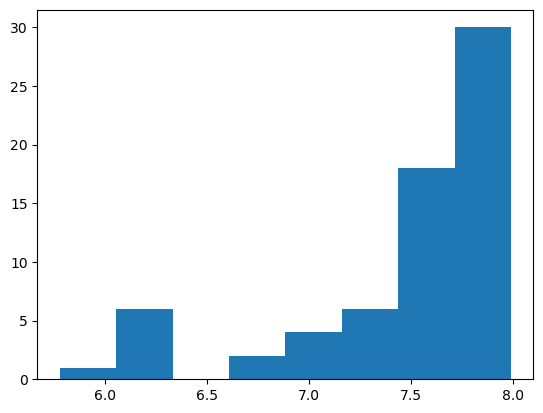

In [19]:
NoBins = 8
pdm=pd.DataFrame(m)
plt.hist(pdm[pdm[0]<NoBins], bins=NoBins)
plt.show()

In [20]:
# Pas het neurale netwerk nogmaals toe, maar nu door de training en test data 
# steeds te splitsen mbv kFold
import os
import scipy
from sklearn.model_selection import KFold
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import r2_score

# https://stackoverflow.com/questions/39758094/clearing-tensorflow-gpu-memory-after-model-execution
from numba import cuda 
#InteractiveSession.close()

TF_CONFIG = ConfigProto()
TF_CONFIG.gpu_options.per_process_gpu_memory_fraction = 0.333
# TF_CONFIG = ConfigProto(gpu_options=GPUOptions(per_process_gpu_memory_fraction=0.1),allow_soft_placement=True)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

#gpu_options = tf.GPUOptions(allow_growth=True)
#session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
#InteractiveSession.close(_self)
# df = x_train[["ClientId", "Periodenummer", "GedeclareerdeKostenExclBtw", "GemeenteId", "nProductID", "nAanbiederID", "EerdereDeclaraties"]]


if HyperparameterTuning == True:
    with tf.device("cpu:0"):
        print("Dimensie van de X-training: " + str(np.shape(x_train)) + " "+ str(type(x_train)))
        print("Dimensie van de X-test: " + str(np.shape(x_test)) + " "+ str(type(x_test)))

        print("\nOptimalisatie beste Neurale Netwerk: aantal nodes per layer en met kFold)")
        NNscores=[]
        ParamScores=[]
        ParamScores.append(["Cnt", "LatentLay", "Dropout", "Param2", "lRate", "DevSet", "Reg", "Opt", "bSize", "Epochs", "Count_train", "Count_test", "R2_train", "R2_test", "x_train", "x_test", "vmse", "vmsetest", "vmae", "vmaetest", "vacc", "vacctest", "vloss", "vlosstest", "vmape", "vmapetest", "Slope"])
        cnt = 0
        Dout = DropoutVal
        DevSet = 0
        if DevSet>0:
            X_train, X_dev = train_test_split(x_train, test_size = DevSet, random_state = 42)
        else:
            X_train = x_train.copy()
        
        for LearnRate in range(0, 20, 20):
            #print("Optimalisatie Param 1; Learning Rate: " + str(float(LearnRate/100000)))
            lRate = LearnRate/100000
            # for dSet in range(1, 2, 1):
                # DevSet = dSet/40
                # X_train, X_dev = train_test_split(x_train, test_size = DevSet, random_state = 42)
            for DropoutV in range(10, 100, 10):
                Dout = float(DropoutV/100)
                print("Dropout: " + str(Dout) )
                for iReg in range(0,1,1):
                    Reg = iReg/100000
                    for Opt in range(2,3,1):
                        for Param2 in range(170,171,1):
                            bSize = 16*1024
                            for LatentLay in range(16,17,1):
                                #InteractiveSession.close(_self)
                                sess = InteractiveSession(config=TF_CONFIG)
                                reset_random_seeds()

                                # def NeuralNetworkModel(Activation, Param1, Param2, Param3, Param4, Param5, Reg, DropoutVal, lr, Optimizer):
                                VAEmodel = NeuralNetworkModel("relu", StartLayer, InnerLayer2, InnerLayer3, InnerLayer4, LatentLay, Reg, Dout, lRate, Opt)
                                cnt=cnt+1
                                NNscores.clear()
                                print("\nParameters bij onderstaande resultaten\nLearningRate:" + str(lRate) + "  Dropout:" + str(Dout) + "  Param2:" + str(Param2) + "  LatentLayer:" + str(LatentLay) + "  DevSet:" + str(DevSet) + "  Reg:" + str(Reg) + "  Opt:" + str(Opt) + "  Batchsize:" + str(bSize) + "  Epochs:" + str(epochs))

                                hist = VAEmodel.fit(X_train, X_train, batch_size=bSize, epochs=epochs, validation_data=(x_test, x_test), callbacks=callbacks_list, verbose=0)

                                vmse = list(hist.history['mse'])[-1]
                                vmsetest = list(hist.history['val_mse'])[-1]
                                vmae = list(hist.history['mae'])[-1]
                                vmaetest = list(hist.history['val_mae'])[-1]
                                vacc = list(hist.history['accuracy'])[-1]
                                vacctest = list(hist.history['val_accuracy'])[-1]
                                vloss = list(hist.history['loss'])[-1]
                                vlosstest = list(hist.history['val_loss'])[-1]
                                vmape = list(hist.history['mape'])[-1]
                                vmapetest = list(hist.history['val_mape'])[-1]
                                vlr = list(hist.history['lr'])[-1]

                                xtrain_pred = VAEmodel.predict(X_train)
                                xtest_pred = VAEmodel.predict(x_test)

                                # Bepaal de R2 score op de training set en bepaals hoeveel records een EUCL DIST < 1 hebben
                                m_train = np.sqrt(np.sum(np.square(np.subtract(xtrain_pred, X_train)), axis=1))
                                count_train = np.count_nonzero(m_train < 1)/X_train.shape[0]
                                r2_train = r2_score(X_train, xtrain_pred)
                                
                                # Bepaal de R2 score op de test set en bepaals hoeveel records een EUCL DIST < 1 hebben
                                m_test = np.sqrt(np.sum(np.square(np.subtract(xtest_pred, x_test)), axis=1))
                                count_test = np.count_nonzero(m_test < 1)/x_test.shape[0]
                                r2_test = r2_score(x_test, xtest_pred)
                                
                                slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(range(1,10), list(hist.history['loss'])[-9:])

                                print ("Loss: " + str(vloss) + "  Loss test-set: " + str(vlosstest))
                                ParamScores.append([cnt, LatentLay, Dout, Param2, vlr, DevSet, Reg, Opt, bSize, epochs, count_train, count_test, r2_train, r2_test, X_train.shape, x_test.shape, vmse, vmsetest, vmae, vmaetest, vacc, vacctest, vloss, vlosstest, vmape, vmapetest, slope])

                                #device = cuda.get_current_device()
                                #device.reset()
                                sess.close()
                                #cuda.select_device(0)
                                #cuda.close()

    fig, axs = plt.subplots(2,1,figsize=(10, 5))
    axs[0].plot(hist.history['loss'], label='train')
    axs[0].plot(hist.history['val_loss'], label='test')
    axs[0].set_title('Loss')
    axs[0].set(xlabel='epoch', ylabel='loss')
    axs[0].legend()

    axs[1].plot(hist.history['mse'], label='train-mse')
    axs[1].plot(hist.history['mae'], label='train-mae')
    axs[1].plot(hist.history['accuracy'], label='train-accuracy')
    axs[1].plot(hist.history['val_mse'], label='test-mse')
    axs[1].plot(hist.history['val_mae'], label='test-mae')
    axs[1].plot(hist.history['val_accuracy'], label='test-accuracy')
    axs[1].set_title('Mse / Mae / Accuracy')
    axs[1].set(xlabel='Epoch', ylabel='Mse / Mae / Accuracy')
    axs[1].legend()
    plt.show() 


In [21]:
if HyperparameterTuning == True:
    df = pd.DataFrame(ParamScores)
    writer = pd.ExcelWriter('test_l2.xlsx', engine='xlsxwriter')
    df.to_excel(writer, sheet_name='testresults', index=False)
    writer.save()
    writer.close()
